# Case Background & Key Questions	

Flatiron Health Insurance (FHI) is a growing private healthcare insurance provider founded on the premise that using data and analytics can improve the health insurance industry by providing better care and offerings to its patients. Every year, the Center for Disease Control (CDC) conducts surveys to understand the latest demographic, health, and fitness trends. You have been tasked with analyzing the recently published results of his years’ survey and providing your recommendations back to the Chief Analytics Officer and Chief Marketing Officer. You have been assigned the task of taking a first look at the data and beginning to answer several key questions:
											 								
1)  How does health status, represented by average number of days with bad physical health in the past month (PHYSHLTH), differ by state? Also provide an indication of distribution using whatever statistics you find suitable.
 												 								
2)  Digging deeper into the data, what are some factors that impact health (i.e. demographics, behaviors, previous illness, etc.)?	
						 						
To get you started, the IT department formatted the data set into a tab delimited text file for only NY, NJ, and CT (FHI’s primary markets) called `case_study.csv`. Below you will find a list of steps/questions that you will need to take in your investigation. The first part of the notebook will be focused on cleaning up your data and visualizing it.  The second part of the data set will be focused on performing statistical tests to make statements with statistical significance.  


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_palette('muted')
%matplotlib inline
from scipy import stats
import statsmodels.api as sm

# pd.read_csv('case_study.csv')

In [3]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col=0)

/Users/arencarpenter/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (171) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0


In [5]:
# Quickly check to see the size of our DF, both rows and columns
df.shape

(34545, 358)

In [6]:
df['PHYSHLTH'].value_counts()

88.0    21296
30.0     2438
2.0      1993
1.0      1538
3.0      1187
5.0      1092
10.0      751
7.0       641
15.0      640
4.0       622
77.0      493
20.0      402
14.0      326
99.0      305
6.0       187
25.0      159
8.0        99
21.0       70
12.0       69
28.0       57
29.0       35
27.0       22
18.0       19
16.0       16
17.0       15
9.0        15
22.0       12
13.0       10
19.0       10
11.0        8
24.0        7
26.0        7
23.0        4
Name: PHYSHLTH, dtype: int64

## Subset your dataframe to only include the states in the tri-state area (NJ, CT, NY)

In [7]:
# your code here
tristate = df[df['_STATE'].isin([9,34,36])]
tristate['state'] = np.where(tristate['_STATE'] == 9,'Connecticut',
                             np.where(tristate['_STATE'] == 34,'New Jersey',
                                      np.where(tristate['_STATE'] == 36,'New York','ERROR')))
tristate['ones'] = np.ones(tristate.shape[0])
df = tristate

Now check to see how large our subset df.

In [8]:
df.shape

(34545, 360)

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code.

In [9]:
df['PHYSHLTH'].describe() # Can see max value is 99 which is a code and not a real day amount

count    34545.000000
mean        60.213403
std         37.504566
min          1.000000
25%         15.000000
50%         88.000000
75%         88.000000
max         99.000000
Name: PHYSHLTH, dtype: float64

## 1. Handle the non-normal values

As you can see from the data dictionary, there are a number of responses that are coded with values that could throw off our descriptive statistics.  Let's clean up by mapping the responses to a more appropriate value, and handling any missing values.  

In [10]:
#your code here
df['new_phys'] = df['PHYSHLTH'].where(df['PHYSHLTH'] != 88.0, 0) # Redefine 88 entries as 0 days sick using vectorized
                                                                 # conditional

df['new_phys'] = df.new_phys.where((df['new_phys'] != 99.0) & (df['new_phys'] != 77.0)) # Remove 99 and 77 values
                                                                                        # these correspond to not 
                                                                                        # answering or 'don't know'.
    
print(df.new_phys.value_counts()) # Print Value Counts to confirm data is clean.

0.0     21296
30.0     2438
2.0      1993
1.0      1538
3.0      1187
5.0      1092
10.0      751
7.0       641
15.0      640
4.0       622
20.0      402
14.0      326
6.0       187
25.0      159
8.0        99
21.0       70
12.0       69
28.0       57
29.0       35
27.0       22
18.0       19
16.0       16
17.0       15
9.0        15
22.0       12
13.0       10
19.0       10
11.0        8
24.0        7
26.0        7
23.0        4
Name: new_phys, dtype: int64


## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a graph shows the distribution of the data.

In [11]:
# descriptive statistics
df.new_phys.describe() # Now our max is 30 days. 

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: new_phys, dtype: float64

Text(0, 0.5, 'Sick Days')

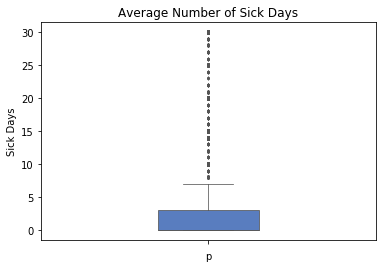

In [12]:
graph = sns.boxplot(x=df.new_phys, orient='v', width=0.3, fliersize=2, linewidth=0.75)
graph.set_title("Average Number of Sick Days")
graph.set_xlabel("p")
graph.set_ylabel("Sick Days")


Text(0, 0.5, 'Count')

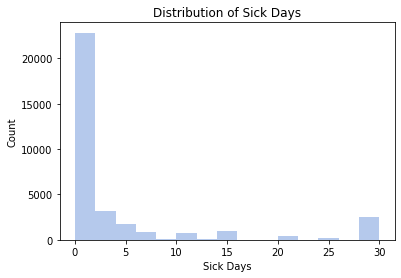

In [13]:
# graphic the distribution of data
graph2 = sns.distplot(df.new_phys, kde=False, bins=15)
graph2.set_title("Distribution of Sick Days")
graph2.set_xlabel("Sick Days")
graph2.set_ylabel("Count")

## 3. Generate a graphic that compares the average number of sick days for each state. 

In [14]:
# code to calculate the average number of sick days by state
by_state = df.groupby('_STATE').new_phys.describe() # Groupby State to see mean.
by_state

,count,mean,std,min,25%,50%,75%,max
_STATE,,,,,,,,
9.0,10413.0,3.688562,8.103732,0.0,0.0,0.0,2.0,30.0
34.0,11458.0,4.380957,8.923776,0.0,0.0,0.0,3.0,30.0
36.0,11876.0,4.148030,8.445330,0.0,0.0,0.0,3.0,30.0


[[Text(0, 0, 'CT'), Text(0, 0, 'NJ'), Text(0, 0, 'NY')]]

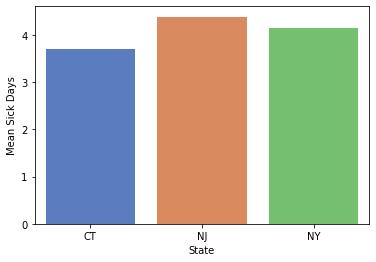

In [15]:
graph3 = sns.barplot(x='_STATE', y='new_phys', data=df, ci = None)  # Mean sick days by state.
graph3.set_xlabel("State")                                          # Set x label.
graph3.set_ylabel("Mean Sick Days")                                 # Set y label.
graph3.set(xticklabels=['CT', 'NJ', 'NY'])                          # Set custom ticks instead of state code.

Text(0.5, 1.0, 'Distribution of Sick Days')

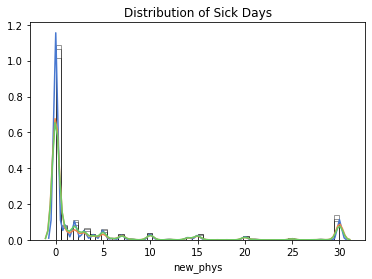

In [77]:
CT = df.loc[df['_STATE'] == 9.0]     # Lookup by statecode.
NJ = df.loc[df['_STATE'] == 34.0]    #
NY = df.loc[df['_STATE'] == 36.0]    #

graph4=sns.distplot(CT.new_phys, kde=True, hist_kws=dict(fill=False)) # Plot sick days dist by state.
sns.distplot(NJ.new_phys, kde=True, hist_kws=dict(fill=False))       # Remove bin fill color.
sns.distplot(NY.new_phys, kde=True, hist_kws=dict(fill=False))       #

graph4.set_title("Distribution of Sick Days")

## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [18]:
# code to create new colum for chronically sick

df['chronic'] = np.where(df['new_phys'] > 12, 1, 0)  #If sick days > 12, classify as chronically ill.
df.chronic.value_counts() # We see 30296 are not chronic, and 4249 are chronic.

0    30296
1     4249
Name: chronic, dtype: int64

In [19]:
df.chronic.describe()

count    34545.000000
mean         0.122999
std          0.328441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: chronic, dtype: float64

## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [20]:
# code to calculate averages per state
state_x_chronic = df.groupby('_STATE').chronic.mean() # Groupby State to see mean.
state_x_chronic # We see its about 12% for all states.

_STATE
9.0     0.110880
34.0    0.134011
36.0    0.122949
Name: chronic, dtype: float64

[[Text(0, 0, 'CT'), Text(0, 0, 'NJ'), Text(0, 0, 'NY')]]

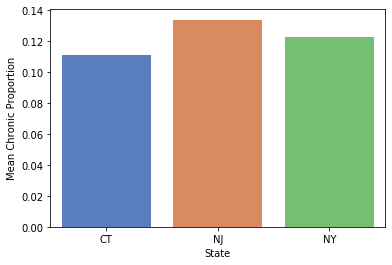

In [21]:
# create graphic to compare chronically sick by state
graph5 = sns.barplot(x='_STATE', y='chronic', data=df, ci = None)   # Mean chronic proportion by state.
graph5.set_xlabel("State")                                          # Set x label.
graph5.set_ylabel("Mean Chronic Proportion")                        # Set y label.
graph5.set(xticklabels=['CT', 'NJ', 'NY'])                          # Set custom ticks instead of state code.

## 6. Independent Variables (categorical)

Does smoking affect the number of days people feel physically ill? 
Let's take the column `SMOKDAY2` and start to prepare it so that we can see how it is possibly correlated to `PHYSHLTH`. When cleaning this data you will find that many respondents were not asked that question. read the codebook to understand why, and use that information when cleaning up your data. I.E, you will need to process two columns in order to create a new column of smokers.

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of 'smokers'.

In [22]:
tristate = df
tristate['smoker'] = np.where(tristate['SMOKE100']==7,"don't know",
                              np.where(tristate['SMOKE100']==9,'refused',
                                       np.where(tristate['SMOKE100']==2,'non-smoker',
                                                np.where(tristate['SMOKDAY2']==7,"don't know",
                                                         np.where(tristate['SMOKDAY2']==9,'refused',
                                                                  np.where(tristate['SMOKDAY2']==3,'non-smoker',
                                                                           np.where(tristate['SMOKDAY2']==2,'some days',
                                                                                    np.where(tristate['SMOKDAY2']==1,'everyday',np.NaN))))))))                   

In [23]:
smokers = tristate.groupby('smoker').count()['state']
smokers = smokers[[3,1,5,0,4]] / smokers.sum()
smokers

smoker
non-smoker    0.833406
everyday      0.077464
some days     0.039687
don't know    0.005211
refused       0.002258
Name: state, dtype: float64

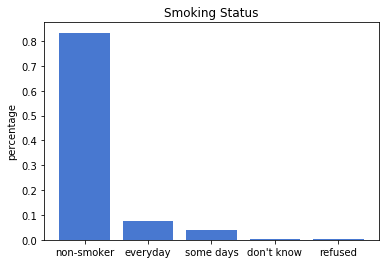

In [24]:
# code to graph those proportion of differen smoking groups using matplotlib
xx_ticks = np.arange(len(smokers.index))
fig1, ax1 = plt.subplots()
ax1.set_title('Smoking Status')
ax1.set_ylabel('percentage')
plt.bar(xx_ticks,smokers);
plt.xticks(xx_ticks,smokers.index);

In [25]:
smoker_states = tristate[['state','smoker']]
smoker_valid = [idx for idx, val in enumerate(smoker_states['smoker']) if val != 'nan']
smoker_states = smoker_states.iloc[smoker_valid]

smoker_states = smoker_states.groupby(['state','smoker'])['smoker'].count()
smoker_count = smoker_states.groupby('state').sum()
smoker_pct = smoker_states / smoker_count

#smoker_pct['Connecticut'][[2,4,1,0,3]]
#smoker_pct['New Jersey'][[2,4,1,0,3]]
smoker_pct['New York'][[2,4,1,0,3]]

smoker
non-smoker    0.859122
some days     0.046127
everyday      0.089157
don't know    0.002668
refused       0.002926
Name: smoker, dtype: float64

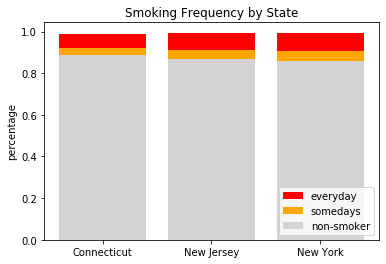

In [26]:
nonsmoker = [smoker_pct['Connecticut'][[2]][0],
             smoker_pct['New Jersey'][[2]][0],
             smoker_pct['New York'][[2]][0]]

some_days = [smoker_pct['Connecticut'][[4]][0],
             smoker_pct['New Jersey'][[4]][0],
             smoker_pct['New York'][[4]][0]]

every_day = [smoker_pct['Connecticut'][[1]][0],
             smoker_pct['New Jersey'][[1]][0],
             smoker_pct['New York'][[1]][0]]

smoke_unk = [smoker_pct['Connecticut'][[0]][0],  #+smoker_pct['Connecticut'][[3]][0],
             smoker_pct['New Jersey'][[0]][0],   #+smoker_pct['New Jersey'][[3]][0],
             smoker_pct['New York'][[0]][0]]     #+smoker_pct['New York'][[3]][0]]

none_some = list(np.array(nonsmoker) + np.array(some_days))
none_some_unk = list(np.array(nonsmoker) + np.array(some_days) + np.array(every_day))

xx_ticks = [0,1,2]
fig1, ax1 = plt.subplots()
ax1.set_title('Smoking Frequency by State')
ax1.set_ylabel('percentage')
pns = plt.bar(xx_ticks,nonsmoker,color='lightgray')
psd = plt.bar(xx_ticks,some_days,bottom=nonsmoker,color='orange')
ped = plt.bar(xx_ticks,every_day,bottom=none_some,color='red')
#puk = plt.bar(xx_ticks,every_day,bottom=none_some_unk)
plt.xticks(xx_ticks,['Connecticut','New Jersey','New York']);
#plt.legend((puk[0],ped[0],psd[0],pns[0]),("don't know",'everyday','somedays','non-smoker'))
plt.legend((ped[0],psd[0],pns[0]),('everyday','somedays','non-smoker'),loc='lower right')

del nonsmoker, some_days, every_day, none_some, none_some_unk, pns, psd, ped #, puk

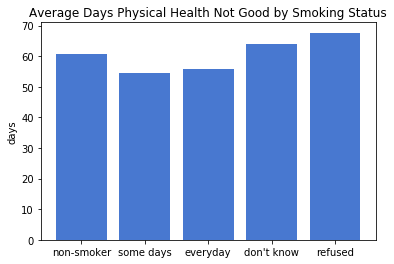

In [27]:
# code to graph these averages sick days for each category of smoking status
smoker_health = tristate[['smoker','PHYSHLTH']]
smoker_valid = [idx for idx, val in enumerate(smoker_health['smoker']) if val != 'nan']
smoker_health = smoker_health.iloc[smoker_valid]
health_valid = [idx for idx, val in enumerate(smoker_health['PHYSHLTH']) if val != 'nan']
smoker_health = smoker_health.iloc[health_valid]

smoker_physhlth = smoker_health.groupby('smoker').mean()
smoker_physhlth = smoker_physhlth['PHYSHLTH'][[2,4,1,0,3]]

xx_ticks = np.arange(len(smoker_physhlth.index))
fig1, ax1 = plt.subplots()
ax1.set_title('Average Days Physical Health Not Good by Smoking Status')
ax1.set_ylabel('days')
plt.bar(xx_ticks,list(smoker_physhlth))
plt.xticks(xx_ticks,smoker_physhlth.index);

## 7. Independent Variables (continuous):

Does the amount of days a person drinks affect the number of days they feel physically ill?
To investigate this, let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [28]:
# code here to clean up the ALCDAY5 responses
df = tristate
df['new_alc'] = df.ALCDAY5.where(df.ALCDAY5 != 888.0, 0)

In [29]:
df.new_alc.value_counts()

0.0      13043
201.0     3027
202.0     2324
101.0     1596
203.0     1350
102.0     1232
230.0     1164
205.0     1156
204.0     1144
210.0      840
103.0      782
107.0      710
220.0      650
215.0      590
206.0      389
104.0      386
208.0      369
105.0      352
207.0      278
225.0      265
777.0      225
999.0      201
212.0      144
106.0      109
228.0       56
214.0       53
229.0       31
209.0       28
227.0       24
218.0       19
226.0       15
216.0       15
224.0       14
222.0       13
221.0       13
213.0       11
211.0       10
217.0        7
223.0        2
219.0        1
Name: new_alc, dtype: int64

In [30]:
conditions = [
    ((df['new_alc'] > 100) & (df['new_alc'] < 108)),
    ((df['new_alc'] > 200) & (df['new_alc'] < 231)),
    df['new_alc'] == 0.0
]

choices = [
    df.new_alc.values - 100,
    df.new_alc.values - 200,
    df.new_alc.values
]


df['new_alc'] = np.select(conditions, choices, default=np.nan)

In [31]:
df.new_alc.unique()

array([ 1., 30.,  0.,  3.,  4.,  5.,  7., 15.,  2., 20., 14., 10., nan,
        8., 29., 27., 26., 16.,  6., 22., 25., 28., 13., 12., 24., 18.,
       17., 21., 11.,  9., 19., 23.])

In [32]:
df.new_alc.dropna(inplace=True)

In [33]:
df.new_alc.unique()

array([ 1., 30.,  0.,  3.,  4.,  5.,  7., 15.,  2., 20., 14., 10.,  8.,
       29., 27., 26., 16.,  6., 22., 25., 28., 13., 12., 24., 18., 17.,
       21., 11.,  9., 19., 23.])

In [34]:
df.new_alc.describe()

count    32212.000000
mean         3.867596
std          6.972380
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         30.000000
Name: new_alc, dtype: float64

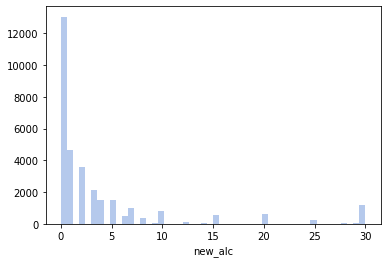

In [35]:
sns.distplot(df.new_alc, hist=True, kde = False)

In [36]:
df.new_alc.corr(df.PHYSHLTH)

0.03462061292339468

## 8. Statistical Inference


- Create a 95% confidence interval for the population mean of physically ill days.

In [37]:
#for new_phys column used mean and std from .describe()
def confidence (mean, std, n):
    z_value = 1.96
    
    return str(mean) + " +- " + str(z_value * (std/n**0.5))

confidence(4.085, 8.51, 33747)

'4.085 +- 0.09079627795475798'

-  Create a 95% confidence interval for the true proportion of chronically sick people.

In [38]:
confidence(0.123, 0.328, 34545)

'0.123 +- 0.0034588945062944258'

## 9. Hypothesis Tests 

**For the follwing questions that require hypothesis tests, you must complete the following:**

*1. Write down the null and alternative hypothesis you are testing.* 

*2. Select the appropriate test and calculate the test statistic and P-values.*

*3. Determine the critical value for the 95% confidence interval.*

*4. Evaluate the test statistic agains the critical value.*

*5. Determine if you reject or fail to reject the null hypothesis and write a sentence explaining the results of your hypothesis test.*  

### The following questions are regarding the `PHYSHLTH` variable. 
- What is the probability of getting this sample mean for days physically ill, if the population mean is 4?


In [39]:
# H0 is that our sample mean is equal to the population mean of 4
# HA is that our sample mean is greater than our population mean

#Using one sample t-test: t-score = sample mean - pop mean / std/sqrt(n)
x_hat = 4.085
mu = 4
s = 8.513
n = 33747

t_score = (x_hat - mu) / (s / (n**.5))
t_score # 1.83423036

# t-score of 1.83 is less than our t-critical value of 1.96 for 95% confidence (using z-score because n > 100) 
# so we cannot reject our null hypothesis and can assume our mean sample is statistically the same as the 
# population mean

1.8342303621197658

- Is there a statistically significant difference between men and women in the number of days a person feels phsyically ill?

In [40]:
from scipy import stats

In [63]:
# H0 is that there is no statistical difference between men and women
# HA is that there is a difference between men and women

# Stat test is two sample t-test
male = df[df.SEX == 1]['new_phys'].dropna()   # Have to drop null for t-test, grab by gender.
female = df[df.SEX == 2]['new_phys'].dropna()

stats.ttest_ind(male, female) #Ttest_indResult(statistic=-7.3333586565586, pvalue=2.2949494325716564e-13)

# t-score of -7.33 is much higher than our t-critical value of 1.96 for 95% confidence (using z-score because n >100)
# so we can reject the null hypothesis and accept our alternative that men and women have different means

Ttest_indResult(statistic=-7.3333586565586, pvalue=2.2949494325716564e-13)

- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states. 

In [42]:
ct = df[df._STATE == 9]['new_phys'].dropna()
nj = df[df._STATE == 34]['new_phys'].dropna()
ny = df[df._STATE == 36]['new_phys'].dropna()

In [64]:
# H0 is that there is no difference between the mean sick days for the three states
# HA is that there is a difference between the mean sick days

# testing more than two sample means, so ANOVA to avoid Type 1 error
stats.f_oneway(ct, nj, ny)

# result: F_onewayResult(statistic=18.558644605907094, pvalue=8.800607044147037e-09)

# pvalue is dramatically lower than alpha 0.05 so can reject null hypothesis and accept the alternative that there is
# significant difference between the means. An ANOVA does not indicate which means are different, only that the three
# are not the same.

F_onewayResult(statistic=18.558644605907094, pvalue=8.800607044147037e-09)

### The following questions are regarding the  `CHRONIC` variable.
- What is the probability of drawing this sample proportion if chronically true population proportion is 0.10?

In [65]:
df.chronic.value_counts()

0    30296
1     4249
Name: chronic, dtype: int64

In [66]:
# H0 is that the sample proportion is statistically the same as the population proportion of 0.1
# HA is that the sample proportion is statistically different from the population proportiona and thus likely belongs
# to a different population

# Sample Proportion
sample_proportion = 4249/34545  # 0.12299898682877407

# Variables
p_hat = 0.1
z = 1.96
n = 34545

# Calculate margin of error
margin_of_error = z * ((p_hat * (1 - p_hat)) / n)**0.5 # 0.00316362302404978

print('Confidence Interval: ' + str((p_hat - margin_of_error)), ((p_hat + margin_of_error)))
# Confidence Interval: 0.09683637697595023 0.10316362302404979

# Our 95% confidence interval for the 0.1 population proportion is (0.097, 0.103) and this does not include our sample
# proportion of 0.123. We can consequently reject our null hypothesis that the sample proportion is included in the 
# population. 

Confidence Interval: 0.09683637697595023 0.10316362302404979


- Is there a statistically significant difference in the percentage of men and women who are chronically sick?

In [67]:
male_chronic = df[df.SEX == 1]['chronic'].dropna()   # Have to drop null, grab by gender.
female_chronic = df[df.SEX == 2]['chronic'].dropna()

In [68]:
male_chronic.value_counts() # See raw data for proportion. 

0    13481
1     1677
Name: chronic, dtype: int64

In [69]:
female_chronic.value_counts() # See raw data for proportion. 

0    16797
1     2569
Name: chronic, dtype: int64

In [70]:
# H0 is that the proportion of chronic illness is the same between men and women
# HA is that the proportion of chronic illness is different between men and women

# Define some variables
p1 = len(male_chronic[male_chronic == 1]) / len(male_chronic) # 0.11063464837049743
p2 = len(female_chronic[female_chronic == 1]) / len(female_chronic) # 0.13265516885262832

p = (len(male_chronic[male_chronic == 1]) + len(female_chronic[female_chronic == 1])) / (len(male_chronic) + len(female_chronic))
# 0.1229869076584405

# Calculate our t-score: 
t_score = (p1 - p2) / ((p * (1 - p) * ((1 / len(male_chronic) + (1 / len(female_chronic)))))** 0.5)
# t-score: -6.182661387825395

# Our t-score is very high and greater than 1.96 so with 95% confidence we can suggest that the two proportions are
# not the same, thus rejecting our null hypothesis. 

- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states.

In [50]:
ct_chronic = df[df._STATE == 9]['chronic'].dropna()   # Groupby State and select Chronic column, dropping the null
nj_chronic = df[df._STATE == 34]['chronic'].dropna()  # values. 
ny_chronic = df[df._STATE == 36]['chronic'].dropna()  # 

In [71]:
# H0 is that there is no difference in chronic illness proportion between the three states. 
# HA is that there is a difference between the states. 

# Using an ANOVA: 
stats.f_oneway(ct_chronic, nj_chronic, ny_chronic)

# Our pvalue of 1.0227916535970232e-06 is much smaller than our threshold alpha of 0.05 and thus we can reject our 
# null hypothesis and determine that there is a difference between the three states for the proportion of chronically
# ill citizens. The ANOVA does not provide what states vary from which, just that there is a difference. 

F_onewayResult(statistic=13.798483896644871, pvalue=1.0227916535970232e-06)

# 10. Independent Investigation

Now that you have invesitgated physical health and chronic sickness and their relationships with states and gender, you will conduct a similar investigation with variables of your choosing. 

Select a continuous dependent varaible and a binary dependent variable that you would like to investigate. Then select a categorical independent variable with at least 3 groups and for which you will test to see if the response to the independent variable affects outcomes of the dependent variable.

For your continuous dependent variable perform the following:
  - Determine the sample mean and sample standard deviation
  - Create a confidence interval for a population mean.
  - Perform a two-sample test of means for gender.
  - Perform a one-way ANOVA using your categorical independent variable.

### Michael Grossman, 1976. Correlation between health and schooling.

In [78]:
##  relationship between health and education
edu_dict = {1:'did not finish',
            2:'high school grad',
            3:'some college',
            4:'college grad',
            9:np.nan}
df['education'] = df['_EDUCAG'].replace(edu_dict)

hlthedu = df[['education','new_phys']].dropna()
#hlthedu.shape
hlthedu.head()

,education,new_phys
49938,college grad,0.0
49939,some college,0.0
49940,college grad,2.0
49941,college grad,0.0
49942,some college,0.0


In [84]:
##  let's create a table and take a closer look
hlthedu_table = hlthedu.groupby('education').mean()['new_phys'][[1,2,3,0]]
hlthedu_table

education
did not finish      7.017364
high school grad    5.124061
some college        4.650706
college grad        2.805341
Name: new_phys, dtype: float64

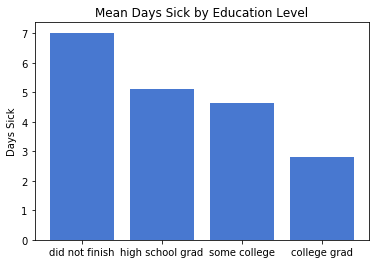

In [85]:
##  now plot relationship between education and health
xx_ticks = np.arange(len(hlthedu_table.index))
fig1, ax1 = plt.subplots()
ax1.set_title('Mean Days Sick by Education Level')
ax1.set_ylabel('Days Sick')
plt.bar(xx_ticks,list(hlthedu_table))
plt.xticks(xx_ticks,hlthedu_table.index);

In [81]:
##  run an ANOVA test
hlthedu_ftest = stats.f_oneway(
    hlthedu['new_phys'][hlthedu['education'] == 'did not finish'],
    hlthedu['new_phys'][hlthedu['education'] == 'high school grad'],
    hlthedu['new_phys'][hlthedu['education'] == 'some college'],
    hlthedu['new_phys'][hlthedu['education'] == 'college grad'])

##  print test results
print('ANOVA test')
print('Null Hypothesis:  Number of Days Sick does not depend on Education')
print('F-stat:   ' + str("{:.4f}".format(hlthedu_ftest.statistic)))
print('p value:    ' + str("{:.4f}".format(hlthedu_ftest.pvalue)))
print('reject the null hypothesis')

ANOVA test
Null Hypothesis:  Number of Days Sick does not depend on Education
F-stat:   262.0295
p value:    0.0000
reject the null hypothesis


Select/create a binary variable from the survey questions as you dependent variable and perform the following:
  - Create a confidence interval for a population proportion.
  - Perform a two proportions z-test using gender.
  - Perform a Chi-Square test using your categorical independent variable.

In [56]:
##  isolate the variables
tristate = df
smokedu = tristate[['smoker','education']].dropna()
smokedu = smokedu.loc[(smokedu.smoker != 'nan')&(smokedu.smoker != "don't know")&(smokedu.smoker != 'refused')]
smokedu.shape

(32682, 2)

In [57]:
##  cross-tabulate
smokedu_crosstab = pd.crosstab(smokedu['education'],smokedu['smoker'])
smokedu_crosstab = smokedu_crosstab.reindex(['did not finish','high school grad','some college','college grad'])
smokedu_crosstab = smokedu_crosstab[['non-smoker','some days','everyday']]
smokedu_crosstab

smoker,non-smoker,some days,everyday
education,,,
did not finish,1749,152,333
high school grad,6445,412,1015
some college,6540,397,776
college grad,13918,403,542


In [58]:
##  get distributions by education level
smokedu_ctdist = smokedu_crosstab
smokedu_ctdist['sum'] = smokedu_ctdist.sum(axis=1)
smokedu_ctdist = smokedu_ctdist.iloc[:,0:3].div(smokedu_ctdist["sum"], axis=0)
print()
print('smoking decreases with educational attainment')
display(round(smokedu_ctdist,3))

##  clean up
smokedu_crosstab = smokedu_crosstab.iloc[:,0:3]
#smokedu_crosstab


smoking decreases with educational attainment


smoker,non-smoker,some days,everyday
education,,,
did not finish,0.783,0.068,0.149
high school grad,0.819,0.052,0.129
some college,0.848,0.051,0.101
college grad,0.936,0.027,0.036


In [59]:
##  calculate the Chi-squared statistic and critical value
chi2stat, pvalue, degfree, expected = stats.chi2_contingency(smokedu_crosstab)
ci_level = 0.95
cvalue = stats.chi2.ppf(ci_level, degfree)

##  print test results
print('Chi-Squared test')
print('Null Hypothesis:  Smoking Status does not depend on Education')
print('Chi2-stat:  ' + str("{:.4f}".format(chi2stat)))
print('p value:       ' + str("{:.4f}".format(pvalue)))
print('reject the null hypothesis')

Chi-Squared test
Null Hypothesis:  Smoking Status does not depend on Education
Chi2-stat:  1018.4375
p value:       0.0000
reject the null hypothesis


In [60]:
##  take the difference between the two tables
##  shows the relationship between education and smoking status
#obs_expect = smokedu_crosstab - expected
#round(obs_expect,1)